# 9x9 RSA (crossvalidated and not crossvalidated)

(Crossvalidated) RSA analysis on 9x9 RDMs using these models:

- identity
- numberline
- extremity
- subject and task specific sample frequency

--> and the orthogonalized version of each of those


For crossvalidation we split each epoch into:

- even trials --> average --> array `A` (9 x n_channels x n_timepoints)
- odd trials --> average --> array `B` (9 x n_channels x n_timepoints)

the empirical RDM, array `C` (9 x 9 x n_timepoints) is then calculated:

```
for t in timepoints:
    - C[0, 0, t] = euclidean_distance(A[0, :, t], B[0, :, t]
    - C[1, 0, t] = euclidean_distance(A[1, :, t], B[0, :, t]
    - C[0, 1, t] = euclidean_distance(A[0, :, t], B[1, :, t]
    - C[1, 1, t] = euclidean_distance(A[1, :, t], B[1, :, t]
    - C[2, 1, t] = euclidean_distance(A[2, :, t], B[1, :, t]
    - etc.
    
```

or in Python code:

```Python
"""example code for cross validated RDM based on two vectors."""
import itertools

import numpy as np
import scipy.spatial


# Pretend we are working at a single timepoint
ndims = 9
nchs = 64

# `a` and `b` are ERPs based on even and uneven trials respectively
a = np.random.random((ndims, nchs))
b = np.random.random((ndims, nchs))

# create the cross validated RDM: `c`
idxs = list(itertools.product(np.arange(ndims), np.arange(ndims)))
c = np.nan * np.zeros((ndims, ndims))
for idx in idxs:
    u = a[idx[0], ...]
    v = b[idx[1], ...]
    c[idx] = scipy.spatial.distance.euclidean(u, v)
    
```


In [1]:
%matplotlib agg

In [2]:
import os
import os.path as op
from warnings import warn
import itertools
import json
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.spatial
import seaborn as sns
import pandas as pd
import mne
from scipy.spatial.distance import pdist, squareform
import scipy.stats

from utils import (
    _rdm2vec,
    BIDS_ROOT,
    _kendall_tau_a,
    extract_sample_frequencies,
    get_model_rdm_dict,
    orth_model_rdms,
    prep_epochs,
    get_mahalanobis_rdm_times,
    calc_sigma,
)

In [3]:
# do not warn about too many figures open
plt.rcParams.update({'figure.max_open_warning': 0})

# Plot model RDMs

In [4]:
# Get overall histogram of number samples
beh_fname = "behavioral_data.csv"
beh_fpath = op.join(BIDS_ROOT, "code", beh_fname)
df = pd.read_csv(beh_fpath)


In [5]:
# settings
double = False  # work on 9x9
with_sides = False
lower_tri = False  # in cross-validated, we work on full RDMs
mean_center = True  


# Get all model RDMs
sample_frequencies = extract_sample_frequencies(df, with_sides=with_sides)
model_rdms = get_model_rdm_dict(
    sample_frequencies, double=double, lower_tri=lower_tri, mean_center=mean_center
)
model_rdms = orth_model_rdms(model_rdms)

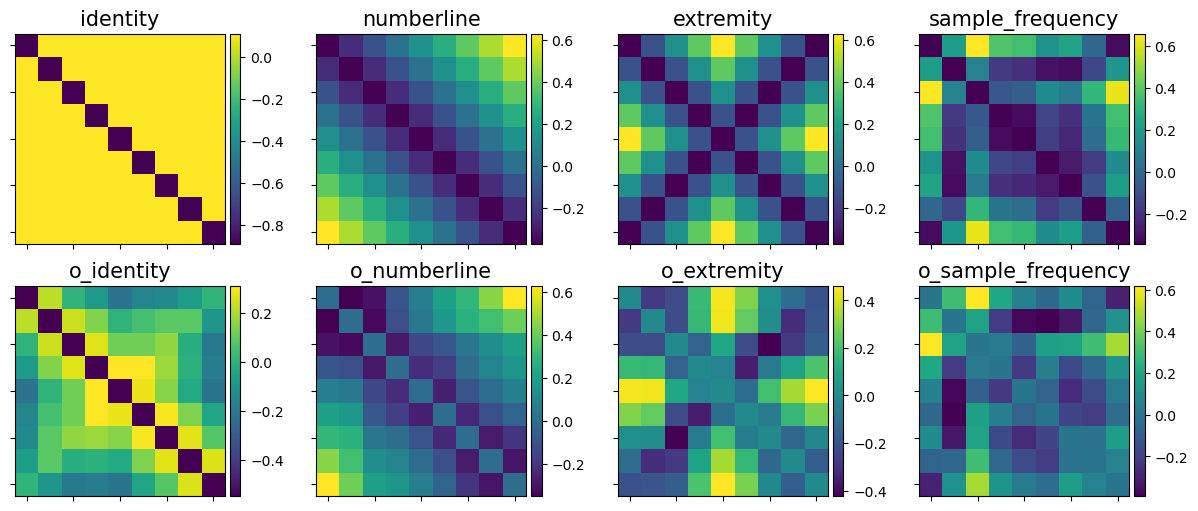

In [6]:
# Plot all RDMs
fig, axs = plt.subplots(2, int(np.ceil(len(model_rdms) / 2)), constrained_layout=True, figsize=(12,5))
for i, (name, model) in enumerate(model_rdms.items()):
    if not lower_tri:
        tmpsquare = model
    else:
        tmpsquare = np.zeros((18, 18)) * np.nan
        idx = np.tril_indices(tmpsquare.shape[0], k=-1)
        tmpsquare[idx] = model    
    
    ax = axs.flat[i]
    im = ax.imshow(tmpsquare)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)    
    plt.colorbar(im, cax=cax)
    
    ax.set_title(name, fontsize=15)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig

# Plot settings

In [7]:
# colors for plots
colors = {
    name: f"C{i}"
    for i, name in enumerate(
        [
            "side",
            "identity",
            "numberline",
            "extremity",
            "sample_frequency",
            "mean_number_extrem",
        ]
    )
}

# Analysis

In [8]:
# IO: Where to find the data
# Where to find epochs
fname_epo_template = op.join(
    BIDS_ROOT, "derivatives", "sub-{0:02}", "sub-{0:02}_epochs-epo.fif.gz"
)

# Where to save RSA results
rsa_9x9 = op.join(BIDS_ROOT, "derivatives", "rsa_9x9")
fname_rsa_results = op.join(rsa_9x9, "{}", "rsa_results.csv")

# Where to save rsa single subj plots
fname_rsa_subj_plots_template = op.join(
    rsa_9x9, "{}", "single_subj_plots", "sub-{:02}_task-{}_{}"
)

# RSA overall plots
fname_rsa_overall_plots_template = op.join(rsa_9x9, "{}", "rsa_{}.pdf")

# Pack all names in a dict
name_templates = dict()
name_templates["epochs"] = fname_epo_template
name_templates["rsa_subj_plots"] = fname_rsa_subj_plots_template
name_templates["rsa_results"] = fname_rsa_results
name_templates["rsa_overall_plots"] = fname_rsa_overall_plots_template

In [9]:
def _build_empirical_rdms(
    epochs,
    preproc_settings,
    crossvalidate,
    distance_metric,
    subj,
    numbers,
    nchs,
    ntimes,
    samp,
    stop,
    half,
    warni=20,
    mnn=False,
    mnn_separate_epoch_types=True,
    mnn_average_over_time=True,
):
    """Build an RDM per timepoint.
    
    Parameters
    ----------
    epochs : mne.Epochs
        The epochs data associated with subj.
    preproc_settings : dict
        The dictionary of preprocessing settings passed to `prep_epochs`.
        Must not contain a key called "crossvalidate".
    crossvalidate : bool
        Whether or not to work on crossvalidated RDMs.        
    distance_metric : str, one of ["euclidean", "correlation"]
        Distance metric to use for calculating RDMs.
    subj : int
        The subject ID.
    numbers : array_like of str
        The sample outcomes (=numbers) to work on. Can also be
        "bins" or "orthogonalized bins". But here referred to as
        "numbers".
    nchs : int
        Number of channels in the data.
    ntimes : int
        Number of timepoints in the data.
    samp : str, one of ["active", "yoked"]
        The type of sampling task to work on.
    stop : str, one of ["fixed", "variable"]
        The type of stopping task to work on.
    half : str, one of ["both", "first_half", "second_half"]
        Which part of the data to work on.
    warni : int
        If number of trials in any epochs object is below `warni`, trigger
        a warning. Defaults to 20
    mnn : bool
        Whether or not to perform multivariate noise normalization.
        Defaults to False.
    mnn_separate_epoch_types : bool
        If True, perform MNN for each epoch selection separately. That is,
        for an epoch from the active/variable condition in the first half,
        calculate a covariance matrix over numbers 1-9 ... and then another
        one for active/variable second half, etc.
        If False, calculate a single covariance matrix to be used for each
        epoch selection. The calculation of that covariance matrix is done
        over sampling and numbers active/1-9, yoked/1-9, because stopping 
        is a between subjects factor. Defaults to True.
    mnn_average_over_time : bool
        If True, the covariance matrix is averaged over timepoints and
        the data is corrected once over all timepoints.
        If False, perform MNN over time. That is, calculate a covariance 
        matrix for each timepoint, and correct the data per timepoint.
        Defaults to True.
    
    Returns
    -------
    rdm_times : ndarray, shape(len(numbers), len(numbers), ntimes)
        The RDMs per timepoint.
    
    """
    # settings for MNN
    preproc_settings_noAverage = {**preproc_settings}
    preproc_settings_noAverage['average'] = False

    # Make sure only EEG channels have been picked
    epochs = epochs.pick_types(meg=False, eeg=True)

    # Collect number ERPs for this subj and task
    if crossvalidate:
        # one for even trials, and one for odd trials (=2)
        data_uV = np.nan * np.zeros((2, len(numbers), nchs, ntimes))
    else:
        data_uV = np.nan * np.zeros((len(numbers), nchs, ntimes))
    

    # If we do multivariate noise normalization, get normalization arrays
    if mnn:

        if mnn_separate_epoch_types:
            # do mnn for each "epoch" selection separately,
            # i.e., calculate a new covariance matrix for each
            # condition like epochs["active"/"variable"/"first_half]
            mnn_conditions = [f"out{i}" for i in range(1, 10)]

            if half == 'both':
                sel_str = f"{samp}/{stop}"
            else:
                sel_str = f"{half}/{samp}/{stop}"

            epochs_sel = epochs[sel_str]
        else:
            # do mnn over all epochs,
            # i.e., calculate a single covariance matrix for all
            # conditions like epochs
            sampling = ("active", "yoked")                                          
            # stopping is a between subj factor, so pre-determined by subject ID
            number = tuple(f"out{i}" for i in range(1, 10)) 
            # we do not enter "half" into the list, because "both" and "first",
            # and "both" and "second" are confounded

            combinations = itertools.product(sampling, number)

            mnn_conditions = ["/".join(combi) for combi in combinations]
            epochs_sel = epochs.copy()  # working on the full epochs, no selection

        sigmas = calc_sigma(
            epochs=epochs_sel,
            preproc_settings=preproc_settings_noAverage,
            crossvalidate=crossvalidate,
            scaletomu=False,
            conditions=mnn_conditions,
            average_over_time=mnn_average_over_time,
        )

    for inumber, number in enumerate(numbers):

        if half == 'both':
            sel_str = f"{samp}/{stop}/{number}"
        else:
            sel_str = f"{half}/{samp}/{stop}/{number}"        
            
        epochs_sel = epochs[sel_str]

        nepos = len(epochs_sel)
        warni = 20
        if nepos < warni:
            warn(f"Less than {warni} epos in {subj}/{sel_str} --> {nepos}")

        if crossvalidate:
            if mnn:
                epo_even, epo_uneven = prep_epochs(
                    epochs_sel, **preproc_settings_noAverage, crossvalidate=True
                )

                sigma_even = sigmas[0]
                sigma_uneven = sigmas[1]

                if mnn_average_over_time:
                    # need to swap axes to multiply "ntrls x nchs x ntimes" with "nchs x nchs"
                    # swap, multiply, swap back - as in code accompanying guggenmos 2018
                    epo_even._data[:] = (epo_even.get_data().swapaxes(1, 2) @ sigma_even).swapaxes(1, 2)
                    epo_uneven._data[:] = (epo_uneven.get_data().swapaxes(1, 2) @ sigma_uneven).swapaxes(1, 2)
                else:
                    # no need to swap axes anymore --> "ntrls x nchs x ntimes", pick times: "ntrls x nchs"
                    # multiply with --> "nchs x nchs x ntimes", pick times: "nchs x nchs"
                    for t in range(ntimes):
                        epo_even._data[..., t] = (epo_even.get_data()[..., t] @ sigma_even[..., t])
                        epo_uneven._data[..., t] = (epo_uneven.get_data()[..., t] @ sigma_uneven[..., t])

                erp_even = epo_even.average()
                erp_uneven = epo_uneven.average()
            else:
                erp_even, erp_uneven = prep_epochs(
                    epochs_sel, **preproc_settings, crossvalidate=True
                )

            # scale MNE internal representation (V) to micro Volts
            data_uV[0, inumber, ...] = erp_even.data * 1e6
            data_uV[1, inumber, ...] = erp_uneven.data * 1e6
        else:
            if mnn:
                epo = prep_epochs(epochs_sel, **preproc_settings_noAverage, crossvalidate=False)
                
                sigma = sigmas[0]

                if mnn_average_over_time:
                    epo._data[:] = (epo.get_data().swapaxes(1, 2) @ sigma).swapaxes(1, 2)
                else:
                    for t in range(ntimes):
                        epo._data[..., t] = (epo.get_data()[..., t] @ sigma[..., t])

                erp = epo.average()
            else:
                erp = prep_epochs(epochs_sel, **preproc_settings, crossvalidate=False)

            data_uV[inumber, ...] = erp.data * 1e6

    # Form RDM out of collected data
    if crossvalidate:
        nparities, nkeys, nchs, ntimes = data_uV.shape
        rdm_times = np.nan * np.zeros((nkeys, nkeys, ntimes))

        for itime in range(ntimes):
            # get the 9x64 data: once for even, once for uneven
            timepoint_data_even = data_uV[0, ..., itime]
            timepoint_data_uneven = data_uV[1, ..., itime]

            # idxs is a list of (x,y) coordinates into the cells of the RDM
            idxs = list(itertools.product(np.arange(nkeys), np.arange(nkeys)))
            rdm = np.nan * np.zeros((nkeys, nkeys))
            for idx in idxs:
                # vectors to calculate a distance between
                u = timepoint_data_even[idx[0], ...]
                v = timepoint_data_uneven[idx[1], ...]

                if distance_metric == "euclidean":
                    rdm[idx] = scipy.spatial.distance.euclidean(u, v)
                elif distance_metric == "correlation":
                    rdm[idx] = scipy.spatial.distance.correlation(u, v)

            rdm_times[..., itime] = rdm
    else:
        nkeys, nchs, ntimes = data_uV.shape
        rdm_times = np.nan * np.zeros((nkeys, nkeys, ntimes))

        for itime in range(ntimes):
            # get the 9x64 data
            timepoint_data = data_uV[..., itime]

            if distance_metric == "euclidean":
                rdm = squareform(pdist(timepoint_data, metric=distance_metric))
            elif distance_metric == "correlation":
                rdm = squareform(pdist(timepoint_data, metric=distance_metric))

            rdm_times[..., itime] = rdm

    return rdm_times

In [10]:
def rsa_timecourse_xval(
    subj,
    df,
    name_templates,
    crossvalidate,
    distance_metric,
    rsa_method,
    preproc_settings,
    exclude_models,
    flip_sign_sample_frequency,
    folder_name,
    half,
    mnn_tuple=(False, True, True),
    equalize_counts=False,
    outcome_column_name="outcome",
):
    """Run crossvalidated RSA for subject and task.

    Also saves plots.

    Parameters
    ----------
    subj : int
        The subject ID.
    df : pandas.DataFrame
        The overall behavioral data frame.
    name_templates : dict
        Dictionary with paths to save data. Must have the following keys:
        ['epochs', 'rsa_subj_plots', 'rsa_results', 'rsa_overall_plots'].
    crossvalidate : bool
        Whether of not to do a crossvalidated RSA.
    distance_metric : str
        Metric to use for calculating empirical RDMs. Must be one of
        ['euclidean', 'correlation', 'mahalanobis'].
    rsa_method : str
        Method to correlated model RDMs with empirical RDMs. Must be one of
        ['pearson', 'kendall_a'].
    preproc_settings : dict
        Preprocessing settings for epochs that are subjected to RSA. Must
        contain the following keys: ['crop', 'tshift', 'smooth', 'baseline'].
    exclude_models : list of str
        Which models to exclude. Must be a key in model_rdms dict.
    flip_sign_sample_frequency : bool
        Whether or not to flip the sign of the sample_frequency model before
        orthogonalization. See:
        https://chat.mpib-berlin.mpg.de/arc/pl/6auntgum8fg8tgr3hktrej69ih
    folder_name : str
        Under which folder to save the RSA results.
    half : 'first_half' | 'second_half' | 'both'
        Which half of samples to take, or both halves.
    mnn_tuple : tuple of bool, len 3
        A tuple with three boolean settings: (1) Whether or not to perform
        multivariate noise normalization. (2) and (3) apply only If (1) is
        True: (2) Whether or not to calc a cov matrix for each epo selection
        separately, (3) Whether or not to do mnn for all timepoints at once.
        Defaults to (False, True, True), so no MNN.
    equalize_counts : bool
        If True, equalize the occurrences of numeric samples for `subj`
        across both tasks (active, and yoked). Note that the "across
        both tasks" addendum is only relevant for subjs that were 
        yoked to *another* subj (not to themselves).
    outcome_column_name : str
        The kind of condition to use for constructing the RDMs. Most often,
        this is "outcome", referring to the numeric samples. But it can also
        be "outcome_bin", or "outcome_bin_orth" to use binned outcomes after
        normalizing them with their trial specific outcome mean, or to
        use them after orthogonalization with the normal "outcomes".    


    Returns
    -------
    df_rsa : pandas.DataFrame
        The RSA data for this subject
    """
    # Stable settings
    if outcome_column_name == "outcome":
        numbers = tuple(f"out{i}" for i in range(1, 10))
    elif outcome_column_name == "outcome_bin":
        numbers = tuple(f"bin{i}" for i in range(1, 10))
    elif outcome_column_name == "outcome_bin_orth":
        numbers = tuple(f"orthbin{i}" for i in range(1, 10))
    else:
        raise ValueError(f"Unsupported outcome_column_name: {outcome_column_name}")

    lower_tri = False if crossvalidate else True

    # unpack other settings
    mnn = mnn_tuple[0]  # if true, do mnn (either guggenmos method, or mahalanobis)
    mnn_separate_epoch_types = mnn_tuple[1]  # if true, do mnn separately for data
    mnn_average_over_time = mnn_tuple[2]  # if true, do mnn *once* for all time

    # identity not possible in 9x9-non-cv
    if ("identity" not in exclude_models) and (crossvalidate is False):
        raise RuntimeError('need to exclude "identity" for no cv.')

    # load epochs
    fname = name_templates["epochs"].format(subj)
    epochs = mne.read_epochs(fname, preload=True, verbose=False)
    epochs.pick_types(meg=False, eeg=True, verbose=False)

    # XXX: If desired, make sure that all number samples have equal occurrences
    #      for all further calculations
    if equalize_counts:
        method = "mintime"  # minimizes bias, is deterministic
        epochs, _ = epochs.equalize_event_counts(event_ids=numbers,
                                                 method=method)

    # figure out time dimension of the data.
    # note that this can change depending on the crop and tshift parameters
    if not isinstance(preproc_settings['crop'], bool):
        if not isinstance(preproc_settings['tshift'], bool):
            # if cropped and shifted
            times = (
                epochs.copy()
                .crop(*preproc_settings['crop'])
                .shift_time(preproc_settings['tshift'], relative=True)
                .times
                )
        else:
            # if only cropped
            times = (
                epochs.copy()
                .crop(*preproc_settings['crop'])
                .times
                )
    else:
        if not isinstance(preproc_settings['tshift'], bool):
            # if only shifted
            times = (
                epochs.copy()
                .shift_time(preproc_settings['tshift'], relative=True)
                .times
                )
        else:
            # if neither cropped nor shifted
            times = epochs.times
    ntimes = len(times)
    nchs = len(epochs.ch_names)
    assert nchs == 64, "Should be working with 64 channels."

    # figure out whether this was variable or fixed stopping ...
    # to get the sampling factor level: one of ['active', 'yoked'].
    keys = np.unique(
        [k for j in [i.split("/") for i in epochs.event_id.keys()] for k in j]
    )
    if "fixed" in keys:
        stop = "fixed"
    elif "variable" in keys:
        stop = "variable"
    else:
        raise RuntimeError(f"Could not make sense out of keys: {keys}")

    # Repeat the following for "samp": ...
    # The sampling factor level: One of ['active', 'yoked'].
    # later concatenate the resulting DFs
    all_dfs = []
    for samp in ("active", "yoked"):

        task = (samp[0] + stop[0]).upper()
        
        if distance_metric == "mahalanobis":
            do_full_mnn = not mnn_separate_epoch_types

            rdm_times, _ = get_mahalanobis_rdm_times(
                subj,
                df,
                epochs,
                preproc_settings,
                samp,
                half,
                zscore_before_regress=True,  # default
                add_constant=False,  # default
                do_full_mnn=do_full_mnn,
                outcome_column_name=outcome_column_name,
                )
        else:
            rdm_times = _build_empirical_rdms(
                epochs,
                preproc_settings,
                crossvalidate,
                distance_metric,
                subj,
                numbers,
                nchs,
                ntimes,
                samp,
                stop,
                half,
                warni=20,
                mnn=mnn,
                mnn_separate_epoch_types=mnn_separate_epoch_types,
                mnn_average_over_time=mnn_average_over_time,                
            )

        # Save the RDMs per timepoint
        fname = name_templates["rsa_subj_plots"].format(folder_name, subj, task, "rdm_times.npy")
        os.makedirs(op.split(fname)[0], exist_ok=True)
        np.save(fname, rdm_times)

        # Build model RDMs for this subj
        df_subj_task = df[(df["subject"] == subj) & (df["task"] == task)]
        sample_frequencies = extract_sample_frequencies(df_subj_task, with_sides=False)
        model_rdms = get_model_rdm_dict(
            sample_frequencies, double=False, lower_tri=lower_tri, mean_center=True
        )

        # potentially exclude models from analysis
        for model_to_exclude in exclude_models:
            del model_rdms[model_to_exclude]

        # potentially try a tweak to get baseline right
        if flip_sign_sample_frequency:
            model_rdms["sample_frequency"] = model_rdms["sample_frequency"] * -1
            warn("flipping sign of sample_frequency due to settings.")

        # get orthogonalized models
        model_rdms = orth_model_rdms(model_rdms)

        # sanity check models are still mean centered
        for name, model in model_rdms.items():
            assert np.isclose(model.mean(), 0)

        # Make and save plot to double check the RDMs
        fig, axs = plt.subplots(
            2,
            int(np.ceil(len(model_rdms) / 2)),
            constrained_layout=True,
            figsize=(12, 5),
        )

        for i, name in enumerate(model_rdms):
            if crossvalidate:
                tmpsquare = model_rdms[name]
            else:
                tmpsquare = np.zeros((9, 9)) * np.nan
                idx = np.tril_indices(tmpsquare.shape[0], k=-1)
                tmpsquare[idx] = model_rdms[name]

            ax = axs.flat[i]
            ax.imshow(tmpsquare)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)

            ax.set_title(name, fontsize=15)
            ax.axis("off")

        fname = name_templates["rsa_subj_plots"].format(folder_name, subj, task, "rdms.pdf")
        os.makedirs(op.split(fname)[0], exist_ok=True)
        fig.savefig(fname)

        # Calculate RSA timecourses
        corr_model_times = np.nan * np.zeros((len(model_rdms), ntimes))
        for imodel, (name, model) in enumerate(model_rdms.items()):

            # Go over timepoints
            for itime in range(ntimes):

                rdm = rdm_times[..., itime]
                vec = _rdm2vec(rdm, lower_tri=lower_tri)
                if crossvalidate:
                    modelvec = _rdm2vec(model, lower_tri=lower_tri)
                else:
                    modelvec = model.copy()

                if rsa_method == "pearson":
                    corr = scipy.stats.pearsonr(vec, modelvec)[0]
                elif rsa_method == "kendall_a":
                    corr = _kendall_tau_a(vec, modelvec)

                corr_model_times[imodel, itime] = corr

        # Prepare as wide data frame, then melt
        df_rsa = pd.DataFrame(corr_model_times.T, columns=model_rdms.keys())
        df_rsa.insert(0, "method", rsa_method)
        df_rsa.insert(0, "time_s", times)
        df_rsa.insert(0, "itime", range(ntimes))
        df_rsa.insert(0, "task", task)
        df_rsa.insert(0, "stopping", stop)
        df_rsa.insert(0, "sampling", samp)
        df_rsa.insert(0, "subject", subj)

        df_rsa = df_rsa.melt(
            id_vars=[
                "subject",
                "task",
                "sampling",
                "stopping",
                "time_s",
                "itime",
                "method",
            ],
            var_name="model",
            value_name="similarity",
        )

        # add boolean column whether orthogonalized
        orth_bools = df_rsa["model"].str.startswith("o_").to_numpy()
        df_rsa.insert(7, "orth", orth_bools)

        # encode orthogonality only in "orth" column, not in model name
        df_rsa.loc[:, "model"] = df_rsa["model"].str.lstrip("o_").to_numpy()

        # append to list of all DFs
        all_dfs.append(df_rsa)

        # Make and save plot to double check timecourses
        fig, ax = plt.subplots()
        sns.lineplot(
            x="time_s",
            y="similarity",
            hue="model",
            style="orth",
            data=df_rsa,
            palette=colors,
            ax=ax,
        )

        fname = name_templates["rsa_subj_plots"].format(
            folder_name, subj, task, "timecourses"
        )
        fig.savefig(fname)

    # Combine both DFs
    df_rsa = pd.concat(all_dfs, ignore_index=True)

    return df_rsa

## run

In [12]:
# settings
run_parallel = False
df = pd.read_csv(beh_fpath)
distance_metric = "euclidean"
equalize_counts = False
outcome_column_name = "outcome"

# mnn_tuple:
# [0] if True, do mnn, else ignore rest of tuple
# [1] if True, do mnn separately for active and yoked, else for active and yoked together
# [2] if True, do mnn once for all timepoints, else per each timepoint
mnn_tuple = (False, False, False)


rsa_method = "pearson"
preproc_settings = {
    "crop": (0.6, 1.6),
    "tshift": -0.8,
    "smooth": 150,
    "baseline": (None, 0),
    "smooth_before_baseline": True,
}
subjects = tuple(range(1, 41))
crossvalidate = False

flip_sign_sample_frequency = False
half = 'both'

NJOBS = min(multiprocessing.cpu_count() - 2, len(subjects))

# which models to exclude (pass empty list otherwise)
exclude_models = ['identity']

# Try to find settings that would overwrite the settings here
configpath = op.join(BIDS_ROOT, 'code', 'rsa_analysis_config.json')
if op.exists(configpath):
    print(f'\n\nOVERWRITTING SETTINGS USING CONFIG:\n{configpath}\n\n')
    with open(configpath, 'r') as fin:
        config = json.load(fin)
    print(config)
    distance_metric = config.get('distance_metric', distance_metric)
    run_parallel = config.get('run_parallel', run_parallel)
    crossvalidate = config.get('crossvalidate', crossvalidate)
    half = config.get('half', half)
    exclude_models = config.get('exclude_models', exclude_models)
    rsa_method = config.get('rsa_method', rsa_method)
    mnn_tuple = config.get('mnn_tuple', mnn_tuple)
    equalize_counts = config.get('equalize_counts', equalize_counts)
    preproc_settings = config.get('preproc_settings', preproc_settings)
    outcome_column_name = config.get('outcome_column_name', outcome_column_name)

# NOTE: all "tuples" that were read from JSON are now "lists",
# because there are no "tuples" in JSON.
# Can also be bool.
try: 
    preproc_settings["crop"] = tuple(preproc_settings["crop"])
except TypeError:
    assert isinstance(preproc_settings["crop"], bool)
try:
    preproc_settings["baseline"] = tuple(preproc_settings["baseline"])
except TypeError:
    assert isinstance(preproc_settings["baseline"], (bool, type(None)))

# NOTE: "identity" MUST be excluded in non-crossval 9x9 RSA
if crossvalidate is False:
    assert 'identity' in exclude_models

# NOTE: "mnn" is automatically done if "mahalanobis" is used
# so mnn_tuple[0] should be True
if distance_metric == "mahalanobis":
    assert mnn_tuple[0] is True, "mahalanobis automatically means MNN"
    
# NOTE: "mahalanobis" currently only supports MNN done per timepoint
# so mnn_tuple[2] should be False
if distance_metric == "mahalanobis":
    assert mnn_tuple[2] is False, "mahalanobis currently only supports MNN per timepoint"

# Construct a string for preproc_settings parameters
preproc_str = ""
for key, val in preproc_settings.items():
    preproc_str += str(key)[0] + "-" + str(val)

# Folder name for saving results
folder_name = (
    f"cv-{crossvalidate}_flip-{flip_sign_sample_frequency}"
    f"_rsa-{rsa_method}"
    f"_dist-{distance_metric}_half-{half.split('_')[0]}"
    f"_exclude-{''.join([i.capitalize() for i in exclude_models])}"
    f"_mnn-{''.join([str(i) for i in mnn_tuple])}"
    f"_ec-{equalize_counts}"
    f"_{preproc_str}"
    f"_{outcome_column_name}"
    )

print(f"using folder_name: {folder_name}")
    
# parallelize
pool_inputs = list(
    itertools.product(
        subjects,
        [df],
        [name_templates],
        [crossvalidate],
        [distance_metric],
        [rsa_method],
        [preproc_settings],
        [exclude_models],
        [flip_sign_sample_frequency],
        [folder_name],
        [half],
        [mnn_tuple],
        [equalize_counts],
        [outcome_column_name],
    )
)

# serial vs parallel version of code
if run_parallel:
    with multiprocessing.Pool(NJOBS) as pool:
        results = pool.starmap(rsa_timecourse_xval, pool_inputs)
else:
    results = []
    for inp in pool_inputs:
        results.append(rsa_timecourse_xval(*inp))

# concatenate results
df_rsa = pd.concat(results, ignore_index=True)

# add some metadata
df_rsa['crossvalidated'] = crossvalidate
df_rsa['baseline_corrected'] = True if isinstance(preproc_settings["baseline"], tuple) else False
df_rsa['distance_metric'] = distance_metric
df_rsa['mnn'] = mnn_tuple[0]
df_rsa['mnn_separate_epoch_types'] = mnn_tuple[1]
df_rsa['mnn_average_over_time'] = mnn_tuple[2]
df_rsa['equalized_counts'] = equalize_counts
df_rsa["outcome_column_name"] = outcome_column_name

# Take mean of numberline and extremity model -> "artificial model"
tmpa = df_rsa[df_rsa['model'] == 'numberline']
tmpb = df_rsa[df_rsa['model'] == 'extremity']

merge_on = list(df_rsa.columns)
merge_on.remove('model')
merge_on.remove('similarity')

tmpc = tmpa.merge(tmpb, on=merge_on)
tmpc['similarity'] = tmpc[['similarity_x', 'similarity_y']].to_numpy().mean(axis=1)
tmpc['model'] = 'mean_number_extrem'
tmpc = tmpc[list(df_rsa.columns)]

df_rsa = pd.concat([df_rsa, tmpc], ignore_index=True)

# save
fname = name_templates["rsa_results"].format(folder_name)
df_rsa.to_csv(fname, index=False)

using folder_name: cv-False_flip-False_long-False_baseline-True_rsa-pearson_dist-euclidean_half-both_exclude-Identity_mnn-True


# Plot each model (all tasks)

In [ ]:
# Make plots by models and save
for meta, grp in df_rsa.groupby(['model', 'orth']):
    
    model = 'o_' + meta[0] if meta[1] else meta[0]
    
    with sns.plotting_context('talk'):
        # Plot this group
        fig, ax = plt.subplots(sharex=True, sharey=True)

        sns.lineplot(x='time_s', y='similarity', ci=68,
                     hue='stopping', style='sampling',
                     hue_order=['fixed', 'variable'],
                     style_order=['active', 'yoked'], legend=False,
                     data=grp, ax=ax)
        ax.set_title(model)
        ax.axhline(0, color='black')
        ax.axvline(0., color='black', linestyle='--')    
        ax.set_xlabel('time (s)')
        ax.set_ylabel(f'similarity ({rsa_method})')

        # add legend
        # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
        legend_elements = [
            Line2D([0], [0], color=sns.color_palette()[1], linestyle='-', label='active/variable'),
            Line2D([0], [0], color=sns.color_palette()[1], linestyle='--', label='yoked/variable'),
            Line2D([0], [0], color=sns.color_palette()[0], linestyle='-', label='active/fixed'),
            Line2D([0], [0], color=sns.color_palette()[0], linestyle='--', label='yoked/fixed'),
            
        ]

        ax.legend(
            handles=legend_elements, loc='best',
            prop={'size': 10}, framealpha=1,
        )

        fig.tight_layout()
        
        # save
        fname = name_templates["rsa_overall_plots"].format(folder_name, model)
        fig.savefig(fname)

# Plot each task (all models)

In [ ]:
# Make plots by task and save
for task, grp in df_rsa.groupby("task"):

    with sns.plotting_context("talk"):
        # Plot this group
        fig, ax = plt.subplots(sharex=True, sharey=True)

        sns.lineplot(
            x="time_s",
            y="similarity",
            ci=68,
            hue="model",
            style='orth',            
            legend="brief",
            data=grp,
            palette=colors,
            ax=ax,
        )
        ax.set_title(task)
        ax.axhline(0, color="black")
        ax.axvline(0.0, color="black", linestyle="--")
        ax.set_xlabel("time (s)")
        ax.set_ylabel(f"similarity ({rsa_method})")

        ax.legend(bbox_to_anchor=(1, 0.5))

        # save
        fname = name_templates["rsa_overall_plots"].format(folder_name, task)
        fig.savefig(fname, bbox_inches="tight")

# Plot mean across tasks

In [ ]:
# Plots of means across tasks

with sns.plotting_context("talk"):
    # Plot this group
    fig, ax = plt.subplots(sharex=True, sharey=True)

    sns.lineplot(
        x="time_s",
        y="similarity",
        ci=68,
        hue="model",
        style='orth',        
        legend="brief",
        data=df_rsa,
        palette=colors,        
        ax=ax,
    )
    ax.set_title('average over tasks')
    ax.axhline(0, color="black")
    ax.axvline(0.0, color="black", linestyle="--")
    ax.set_xlabel("time (s)")
    ax.set_ylabel(f"similarity ({rsa_method})")

    ax.legend(bbox_to_anchor=(1, 0.5))

    # save
    fname = name_templates["rsa_overall_plots"].format(folder_name, 'overall')
    fig.savefig(fname, bbox_inches="tight")

# Plot numberline + extremity averaged

In [ ]:
# which models to average
models_to_average = ['numberline', 'extremity']
df_rsa_selection = df_rsa[df_rsa['model'].isin(models_to_average)]

for meta, grp in df_rsa_selection.groupby('orth'):

    pltsavelabel = 'orth' if meta else ''
    
    with sns.plotting_context("talk"):
        # Plot this group
        fig, ax = plt.subplots(sharex=True, sharey=True)

        sns.lineplot(
            x="time_s",
            y="similarity",
            ci=68,
            hue="stopping",
            hue_order=['fixed', 'variable'],
            style='sampling',
            style_order=['active', 'yoked'],
            legend=False,
            data=grp,
            ax=ax,
        )
        ax.set_title(f'averaged models: {models_to_average}' + pltsavelabel)
        ax.axhline(0, color="black")
        ax.axvline(0.0, color="black", linestyle="--")
        ax.set_xlabel("time (s)")
        ax.set_ylabel(f"similarity ({rsa_method})")

        # add legend
        # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
        legend_elements = [
            Line2D([0], [0], color=sns.color_palette()[1], linestyle='-', label='active/variable'),
            Line2D([0], [0], color=sns.color_palette()[1], linestyle='--', label='yoked/variable'),
            Line2D([0], [0], color=sns.color_palette()[0], linestyle='-', label='active/fixed'),
            Line2D([0], [0], color=sns.color_palette()[0], linestyle='--', label='yoked/fixed'),
            
        ]

        ax.legend(
            handles=legend_elements,
            prop={'size': 10}, framealpha=1,
            bbox_to_anchor=(1, 0.5)
        )        

        # save
        fname = name_templates["rsa_overall_plots"].format(folder_name, 'averaged_models' + pltsavelabel)
        fig.savefig(fname, bbox_inches="tight")